# Module 2 EDA

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

C помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы. Чтобы определиться с параметрами будущей модели, проведите разведывательный анализ данных и составьте отчёт по его результата

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

sns.set()
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

In [2]:
df = pd.read_csv('stud_math.xls')

# Предобработка

In [3]:
def drow_boxplot(data, column):
    """Функция упрощает отрисовку boxplot для анализируемого столбца и столбца score """
    sns.boxplot(x=data[column])


def drow_hist_joinplot(dt, column, column_bins):
    """Функция отрисовывает гистограмму и jointplot для столбца column
     в интервале (perc25 - 1.5 * IQR, perc75 +  1.5 * IQR) и для столбща столбца score"""
    median = dt[column].median()
    IQR = dt[column].quantile(0.75) - dt[column].quantile(0.25)
    perc25 = dt[column].quantile(0.25)
    perc75 = dt[column].quantile(0.75)

    if perc75 != perc25:
        dt[column][dt[column].between(perc25 - 1.5 * IQR, perc75 +
                                      1.5 * IQR)].hist(bins=column_bins,
                                                       label='IQR')
        plt.legend()
        sns.jointplot(x=column,
                      y='score',
                      data=dt[dt[column] < perc75 + 1.5 * IQR],
                      kind='reg')
    else:
        dt[column].hist(bins=column_bins, label='All data')
        plt.legend()
        sns.jointplot(x=column, y='score', data=dt)


def print_data_col_info(data, column_a, column_b):
    """Функция отрисовывает гистограмму и jointplot, а также информацию о количестве выбросов, 
    пустых значений, коэфф. корреляции, ..."""

    display(pd.DataFrame(data[column_a].value_counts()))
    median = data[column_a].quantile(0.5)
    IQR = data[column_a].quantile(0.75) - data[column_a].quantile(0.25)
    perc25 = data[column_a].quantile(0.25)
    perc75 = data[column_a].quantile(0.75)
    if column_a != column_b:
        Kcor = round(
            data[[column_a, column_b]].corr(method='pearson')[column_a][1], 3)
    else:
        Kcor = 1
    nan = int(len(data) -
              data[column_a].describe()[0])  # количество 'nan' значений

    left_border = len(data[data[column_a] < perc25 - 1.5 * IQR])
    right_border = len(data[data[column_a] > perc75 + 1.5 * IQR])

    outliers = left_border + right_border

    print(
        " 25-й перцентиль: {},\n".format(perc25),
        "75-й перцентиль: {},\n".format(perc75),
        "Медиана: {},\n".format(median), "IQR: {},\n".format(IQR),
        "Количество 'nan' значений: {},\n".format(nan),
        "Количество выбросов: {}, слева: {}, справа: {}\n".format(
            outliers, left_border, right_border),
        "Границы выбросов: [{f}, {l}],\n".format(f=perc25 - 1.5 * IQR,
                                                 l=perc75 + 1.5 * IQR),
        "Kоэф. корреляции между \'{}\' и \'{}\' : {},\n".format(
            column_a, column_b, Kcor))


def clean_outliers(column):
    """Функция удаляет выбросы в столбце"""
    global df
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    df = df.loc[df[column].between(perc25 - 1.5 * IQR, perc75 + 1.5 * IQR)]


def drow_nomin_hist(data, column, column_beans):
    """Функция отрисовыват гистограмму для номинативных признаков"""
    data[column].hist(bins=column_beans)


def print_nomin_info(data, column):
    """Функция выводит информацию о номинативном признаке """
    data[column] = data[column].astype(str).apply(lambda x: None if x.strip() == '' else x)
    display(pd.DataFrame(data[column].value_counts()))
    print("Значений, встретившихся в столбце более 10 раз:",
          (data[column].value_counts() > 10).sum())
    print("Уникальных значений:", data[column].nunique())
    data.loc[:, [column]].info()


def drow_nomin_boxplot(column):
    """Функция отрисовывает boxplot, а перед этим заменяет значения nan на None"""
    df[column] = df[column].apply(lambda x: None if x == 'nan' else x)
    lenght = len(df[column].value_counts())
    Y = 3
    X = Y * lenght

    fig, ax = plt.subplots(figsize=(X, Y))
    sns.boxplot(x=column,
                y='score',
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def get_stat_dif(column):
    """Функция ищет статистическую разницу в распределении оценок по номинативным признакам, 
    с помощью теста Стьюдента"""
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'],
                        df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки',
                  column)
            break

col_list = [
    'school', 'sex', 'age', 'address', 'fam_size', 'parent_status',
    'mother_edu', 'father_edu', 'mother_job', 'father_job', 'reason',
    'guardian', 'travel_time', 'study_time', 'failures', 'school_sup',
    'fam_sup', 'paid', 'activities', 'nursery', 'higher', 'internet',
    'romantic', 'fam_rel', 'free_time', 'go_out', 'health', 'absences', 'score'
]
            
def change_col_names(column_list):
    df.columns = column_list

# I Первичный отсмотр данных

In [4]:
display(df.head(10))
df.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [5]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,395.000000,392.000000,371.000000,367.000000,388.000000,373.000000,388.000000,368.000000,384.000000,387.000000,380.000000,383.000000,389.000000
mean,16.696203,2.750000,2.614555,1.438692,2.038660,0.337802,-6.115979,3.937500,3.231771,3.105943,3.531579,7.279373,52.262211
std,1.276043,1.098127,2.228732,0.694181,0.842078,0.743135,2.526235,0.927277,0.993940,1.115896,1.396019,23.465197,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


### Удаляем излишние данные 

In [6]:
df.drop(['studytime, granular'], inplace=True, axis=1)

### Переименовываем столбцы

In [7]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout',
       'health', 'absences', 'score'],
      dtype='object')

In [8]:
change_col_names(col_list)

# II Первичный анализ данных в числовых столбцах

## 1. Столбец age

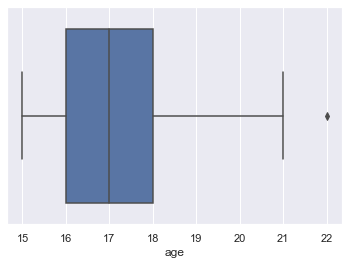

In [9]:
drow_boxplot(df, 'age')

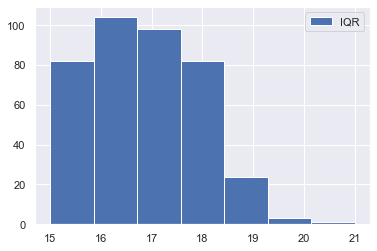

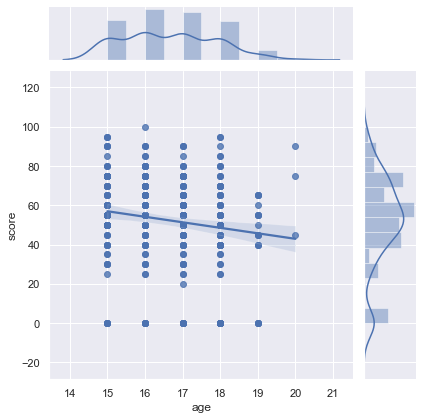

In [10]:
drow_hist_joinplot(df, 'age', 7)

In [11]:
print_data_col_info(df, 'age', 'score')
clean_outliers('age')

,age
16,104
17,98
18,82
15,82
19,24
20,3
22,1
21,1


 25-й перцентиль: 16.0,
 75-й перцентиль: 18.0,
 Медиана: 17.0,
 IQR: 2.0,
 Количество 'nan' значений: 0,
 Количество выбросов: 1, слева: 0, справа: 1
 Границы выбросов: [13.0, 21.0],
 Kоэф. корреляции между 'age' и 'score' : -0.156,



Данные расположены относительно равномерно в диапазоне от 15 до 21 года с медианой - 17 лет и выбросом - 22 года. Ккор =-0.156 т.е. чем выше возраст, тем ниже баллы.

## 2. Столбец mother_edu
образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

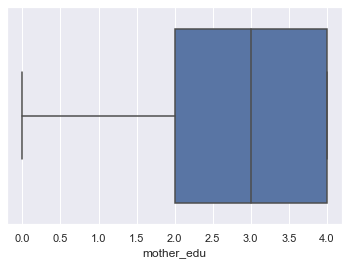

In [12]:
drow_boxplot(df, 'mother_edu')

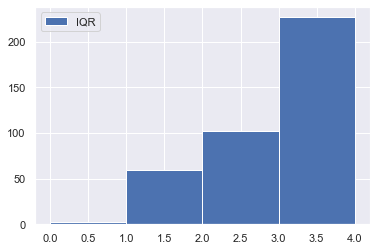

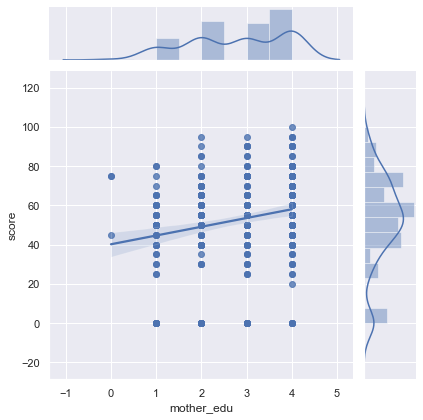

In [13]:
drow_hist_joinplot(df, 'mother_edu', 4)

In [14]:
print_data_col_info(df, 'mother_edu', 'score')
clean_outliers('mother_edu')

,mother_edu
4.0,131
2.0,102
3.0,96
1.0,59
0.0,3


 25-й перцентиль: 2.0,
 75-й перцентиль: 4.0,
 Медиана: 3.0,
 IQR: 2.0,
 Количество 'nan' значений: 3,
 Количество выбросов: 0, слева: 0, справа: 0
 Границы выбросов: [-1.0, 7.0],
 Kоэф. корреляции между 'mother_edu' и 'score' : 0.214,



В столбце есть 3 значения 'nan', выбросы отсутствуют.
Образование матерей относительно неравномерное, видно что большое количество матерей по сравнению с отцами имеют высшее образование.

## 3. Столбец father_edu
образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

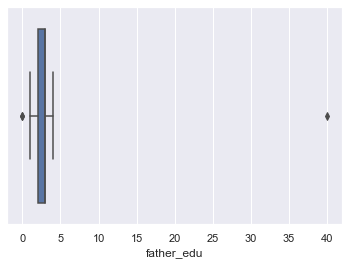

In [15]:
drow_boxplot(df, 'father_edu')

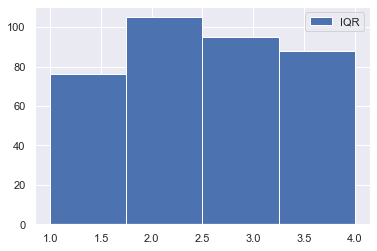

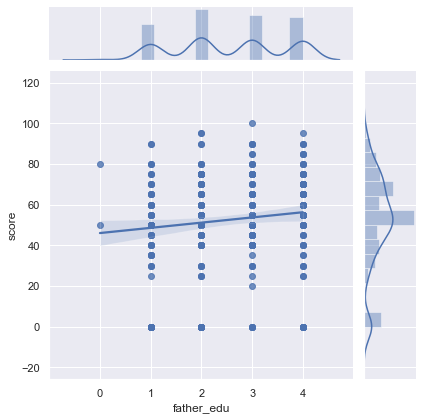

In [16]:
drow_hist_joinplot(df, 'father_edu', 4)

In [17]:
print_data_col_info(df, 'father_edu', 'score')
clean_outliers('father_edu')

,father_edu
2.0,105
3.0,95
4.0,88
1.0,76
0.0,2
40.0,1


 25-й перцентиль: 2.0,
 75-й перцентиль: 3.0,
 Медиана: 3.0,
 IQR: 1.0,
 Количество 'nan' значений: 24,
 Количество выбросов: 3, слева: 2, справа: 1
 Границы выбросов: [0.5, 4.5],
 Kоэф. корреляции между 'father_edu' и 'score' : 0.075,



Образование отцов имеет более равномерное распределение по сравнению с образованием матерей. Связь между образованием отцов и матерей не значительная Ккор = 0.275

## 4. Столбец travel_time
время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

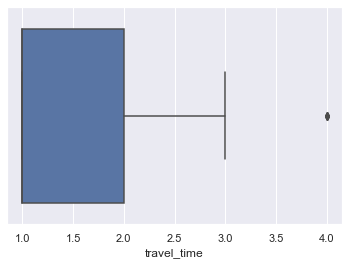

In [18]:
drow_boxplot(df, 'travel_time')

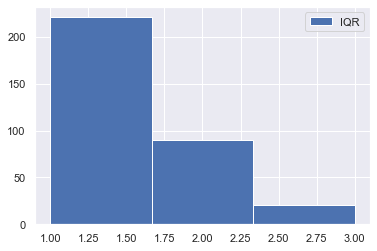

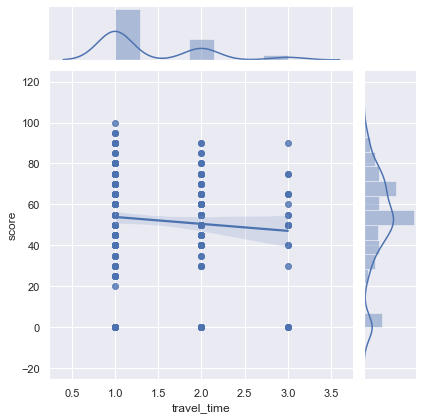

In [19]:
drow_hist_joinplot(df, 'travel_time', 3)

In [20]:
print_data_col_info(df, 'travel_time', 'score')
clean_outliers('travel_time')

,travel_time
1.0,221
2.0,90
3.0,21
4.0,7


 25-й перцентиль: 1.0,
 75-й перцентиль: 2.0,
 Медиана: 1.0,
 IQR: 1.0,
 Количество 'nan' значений: 25,
 Количество выбросов: 7, слева: 0, справа: 7
 Границы выбросов: [-0.5, 3.5],
 Kоэф. корреляции между 'travel_time' и 'score' : -0.085,



## 5. Столбец study_time
время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

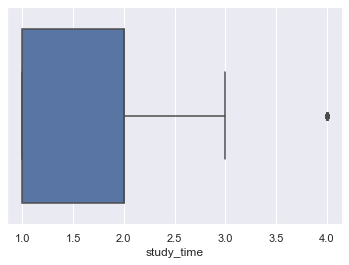

In [21]:
drow_boxplot(df, 'study_time')

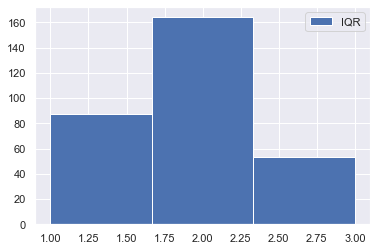

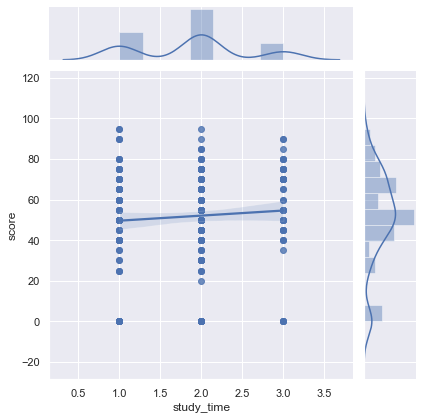

In [22]:
drow_hist_joinplot(df, 'study_time', 3)

In [23]:
print_data_col_info(df, 'study_time', 'score')
clean_outliers('study_time')

,study_time
2.0,164
1.0,87
3.0,53
4.0,22


 25-й перцентиль: 1.0,
 75-й перцентиль: 2.0,
 Медиана: 2.0,
 IQR: 1.0,
 Количество 'nan' значений: 6,
 Количество выбросов: 22, слева: 0, справа: 22
 Границы выбросов: [-0.5, 3.5],
 Kоэф. корреляции между 'study_time' и 'score' : 0.107,



## 6. Столбец failures
количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

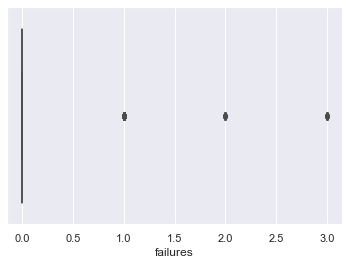

In [24]:
drow_boxplot(df, 'failures')

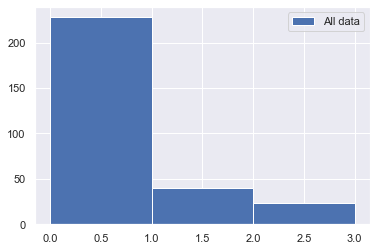

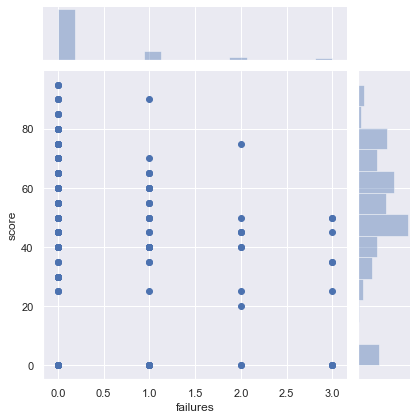

In [25]:
drow_hist_joinplot(df, 'failures', 3)

In [26]:
print_data_col_info(df, 'failures', 'score')
# clean_outliers('failures')

,failures
0.0,228
1.0,40
2.0,12
3.0,11


 25-й перцентиль: 0.0,
 75-й перцентиль: 0.0,
 Медиана: 0.0,
 IQR: 0.0,
 Количество 'nan' значений: 13,
 Количество выбросов: 63, слева: 0, справа: 63
 Границы выбросов: [0.0, 0.0],
 Kоэф. корреляции между 'failures' и 'score' : -0.359,



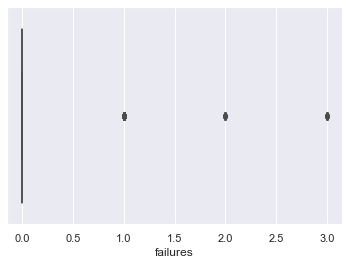

In [27]:
drow_boxplot(df, 'failures')

## 7. Столбец fam_rel 
емейные отношения (от 1 - очень плохо до 5 - очень хорошо)

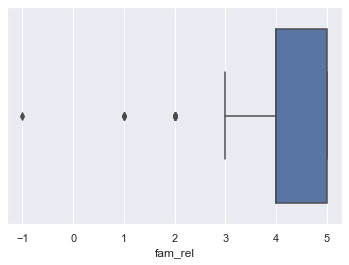

In [28]:
drow_boxplot(df, 'fam_rel')

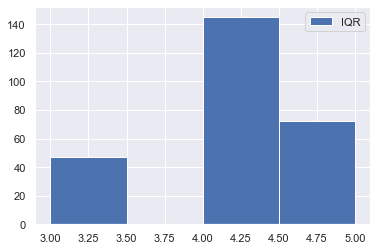

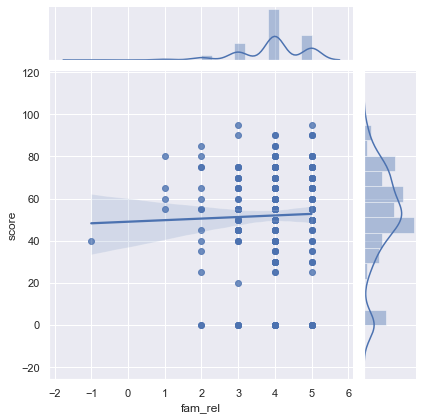

In [29]:
drow_hist_joinplot(df, 'fam_rel', 4)

In [30]:
print_data_col_info(df, 'fam_rel', 'score')
clean_outliers('fam_rel')

,fam_rel
4.0,145
5.0,72
3.0,47
2.0,14
1.0,4
-1.0,1


 25-й перцентиль: 4.0,
 75-й перцентиль: 5.0,
 Медиана: 4.0,
 IQR: 1.0,
 Количество 'nan' значений: 21,
 Количество выбросов: 19, слева: 19, справа: 0
 Границы выбросов: [2.5, 6.5],
 Kоэф. корреляции между 'fam_rel' и 'score' : 0.031,



## 8. Столбец free_time
свободное время после школы (от 1 - очень мало до 5 - очень мого)

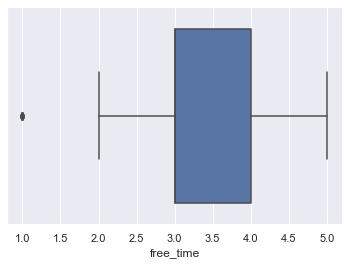

In [31]:
drow_boxplot(df, 'free_time')

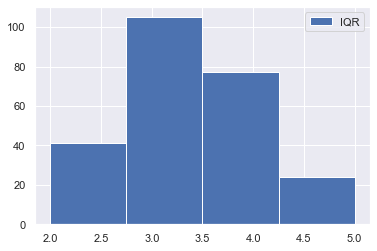

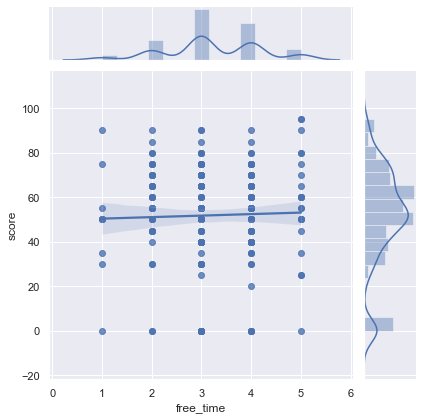

In [32]:
drow_hist_joinplot(df, 'free_time', 4)

In [33]:
print_data_col_info(df, 'free_time', 'score')
clean_outliers('father_edu')

,free_time
3.0,105
4.0,77
2.0,41
5.0,24
1.0,10


 25-й перцентиль: 3.0,
 75-й перцентиль: 4.0,
 Медиана: 3.0,
 IQR: 1.0,
 Количество 'nan' значений: 7,
 Количество выбросов: 10, слева: 10, справа: 0
 Границы выбросов: [1.5, 5.5],
 Kоэф. корреляции между 'free_time' и 'score' : 0.03,



## 9. Столбец go_out
проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

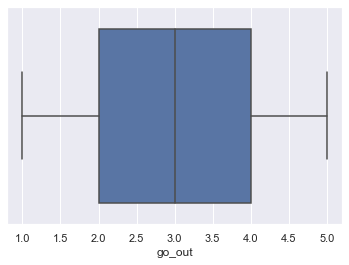

In [34]:
drow_boxplot(df, 'go_out')

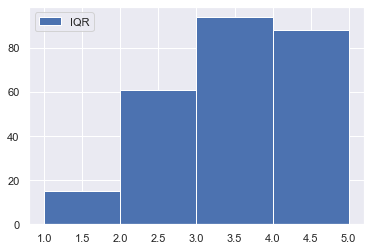

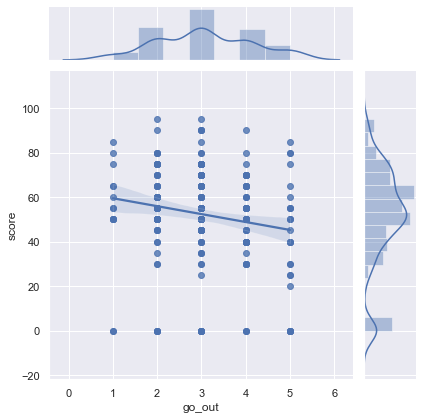

In [35]:
drow_hist_joinplot(df, 'go_out', 4)

In [36]:
print_data_col_info(df, 'go_out', 'score')
clean_outliers('go_out')

,go_out
3.0,94
2.0,61
4.0,59
5.0,29
1.0,15


 25-й перцентиль: 2.0,
 75-й перцентиль: 4.0,
 Медиана: 3.0,
 IQR: 2.0,
 Количество 'nan' значений: 6,
 Количество выбросов: 0, слева: 0, справа: 0
 Границы выбросов: [-1.0, 7.0],
 Kоэф. корреляции между 'go_out' и 'score' : -0.173,



## 10. Столбец health
текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

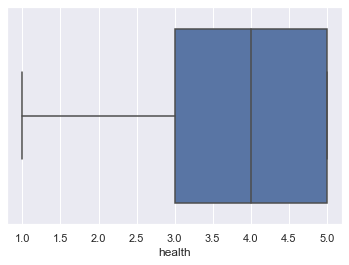

In [37]:
drow_boxplot(df, 'health')

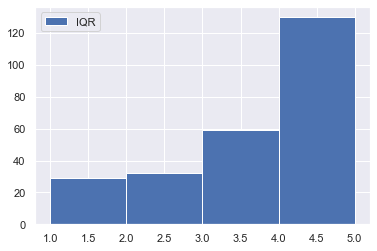

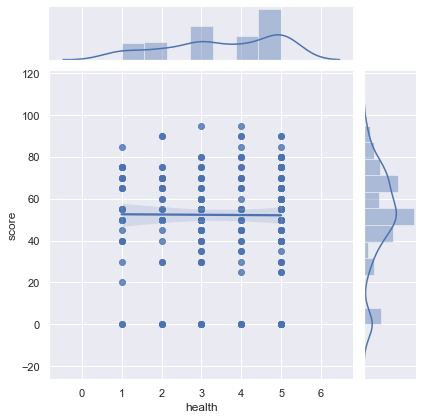

In [38]:
drow_hist_joinplot(df, 'health', 4)

In [39]:
print_data_col_info(df, 'health', 'score')
clean_outliers('health')

,health
5.0,87
3.0,59
4.0,43
2.0,32
1.0,29


 25-й перцентиль: 3.0,
 75-й перцентиль: 5.0,
 Медиана: 4.0,
 IQR: 2.0,
 Количество 'nan' значений: 8,
 Количество выбросов: 0, слева: 0, справа: 0
 Границы выбросов: [0.0, 8.0],
 Kоэф. корреляции между 'health' и 'score' : -0.007,



## 11. Столбец absences
количество пропущенных занятий

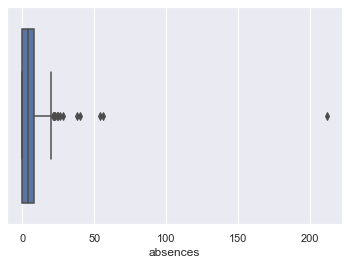

In [40]:
drow_boxplot(df, 'absences')

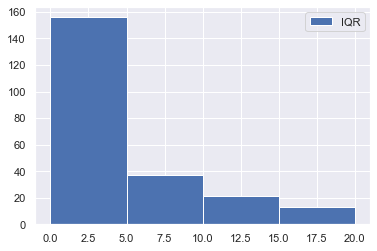

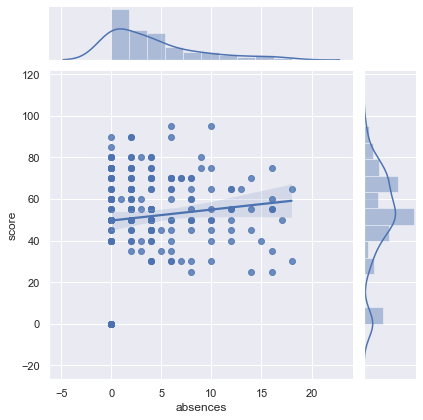

In [41]:
drow_hist_joinplot(df, 'absences', 4)

In [42]:
print_data_col_info(df, 'absences', 'score')
clean_outliers('absences')

,absences
0.0,74
2.0,38
4.0,38
6.0,17
8.0,13
10.0,9
12.0,7
16.0,6
3.0,5
14.0,4


 25-й перцентиль: 0.0,
 75-й перцентиль: 8.0,
 Медиана: 4.0,
 IQR: 8.0,
 Количество 'nan' значений: 9,
 Количество выбросов: 14, слева: 0, справа: 14
 Границы выбросов: [-12.0, 20.0],
 Kоэф. корреляции между 'absences' и 'score' : 0.014,



## 12. Столбец score  
баллы по госэкзамену по математике

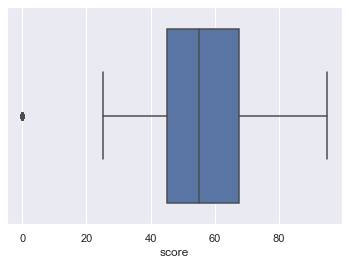

In [43]:
drow_boxplot(df, 'score')

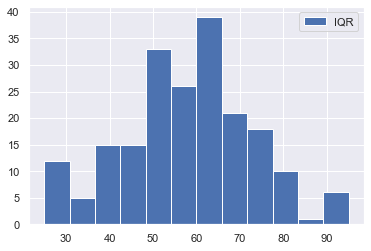

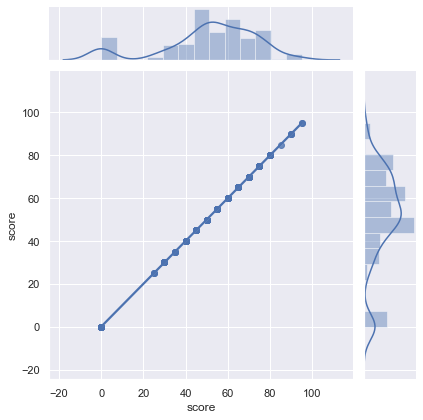

In [44]:
drow_hist_joinplot(df, 'score', 12)

In [45]:
print_data_col_info(df, 'score', 'score')
clean_outliers('score')

,score
50.0,33
55.0,26
0.0,22
65.0,21
70.0,21
60.0,18
75.0,18
40.0,15
45.0,15
80.0,10


 25-й перцентиль: 45.0,
 75-й перцентиль: 67.5,
 Медиана: 55.0,
 IQR: 22.5,
 Количество 'nan' значений: 4,
 Количество выбросов: 22, слева: 22, справа: 0
 Границы выбросов: [11.25, 101.25],
 Kоэф. корреляции между 'score' и 'score' : 1,



# Анализ номинативных переменных

## 13. Столбец school     
аббревиатура школы, в которой учится ученик

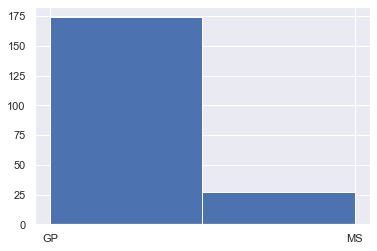

In [46]:
drow_nomin_hist(df, 'school', 2)

In [47]:
print_nomin_info(df, 'school')

,school
GP,174
MS,27


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2
<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   school  201 non-null    object
dtypes: object(1)
memory usage: 3.1+ KB


## 14. Столбец sex      
пол ученика ('F' - женский, 'M' - мужской)

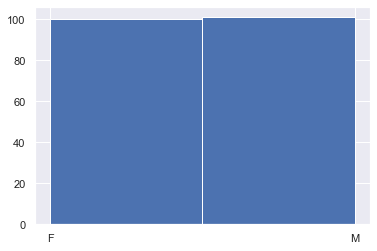

In [48]:
drow_nomin_hist(df, 'sex', 2)

In [49]:
print_nomin_info(df, 'sex')

,sex
M,101
F,100


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2
<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     201 non-null    object
dtypes: object(1)
memory usage: 3.1+ KB


## 15. Столбец address 
тип адреса ученика ('U' - городской, 'R' - за городом)

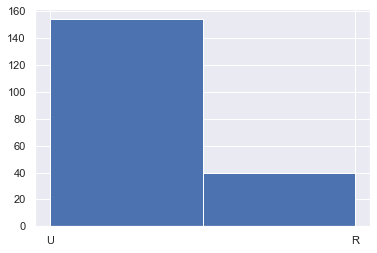

In [50]:
drow_nomin_hist(df, 'address', 2)

In [51]:
print_nomin_info(df, 'address')

,address
U,154
R,40
nan,7


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 3
<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  201 non-null    object
dtypes: object(1)
memory usage: 3.1+ KB


## 16. Столбец fam_size  
размер семьи('LE3' <= 3, 'GT3' >3)

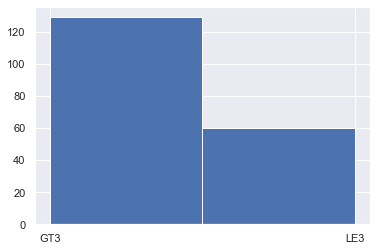

In [52]:
drow_nomin_hist(df, 'fam_size', 2)

In [53]:
print_nomin_info(df, 'fam_size')

,fam_size
GT3,129
LE3,60
nan,12


Значений, встретившихся в столбце более 10 раз: 3
Уникальных значений: 3
<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fam_size  201 non-null    object
dtypes: object(1)
memory usage: 3.1+ KB


## 17. Столбец parent_status 
статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

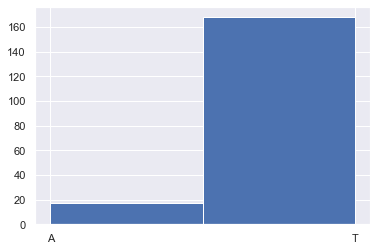

In [54]:
drow_nomin_hist(df, 'parent_status', 2)

In [55]:
print_nomin_info(df, 'parent_status')

,parent_status
T,168
A,17
nan,16


Значений, встретившихся в столбце более 10 раз: 3
Уникальных значений: 3
<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 394
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   parent_status  201 non-null    object
dtypes: object(1)
memory usage: 3.1+ KB


## 18. Столбец mother_job 
работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

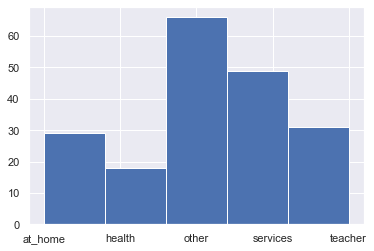

In [56]:
drow_nomin_hist(df, 'mother_job', 5)

In [57]:
print_nomin_info(df, 'mother_job')

,mother_job
other,66
services,49
teacher,31
at_home,29
health,18
nan,8


Значений, встретившихся в столбце более 10 раз: 5
Уникальных значений: 6
<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   mother_job  201 non-null    object
dtypes: object(1)
memory usage: 3.1+ KB


## 19. Столбец father_job 
работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

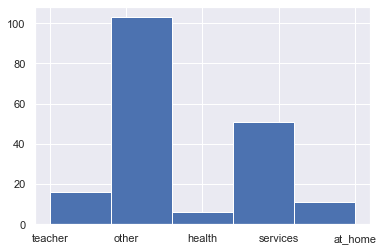

In [58]:
drow_nomin_hist(df, 'father_job', 5)

In [59]:
print_nomin_info(df, 'father_job')

,father_job
other,103
services,51
teacher,16
nan,14
at_home,11
health,6


Значений, встретившихся в столбце более 10 раз: 5
Уникальных значений: 6
<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   father_job  201 non-null    object
dtypes: object(1)
memory usage: 3.1+ KB


## 20. Столбец reason
причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

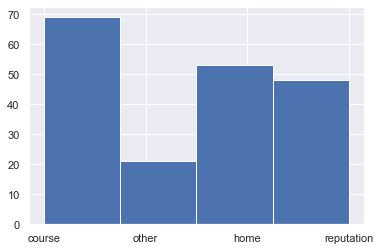

In [60]:
drow_nomin_hist(df, 'reason', 4)

In [61]:
print_nomin_info(df, 'reason')

,reason
course,69
home,53
reputation,48
other,21
nan,10


Значений, встретившихся в столбце более 10 раз: 4
Уникальных значений: 5
<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  201 non-null    object
dtypes: object(1)
memory usage: 3.1+ KB


## 21. Столбец guardian
опекун ('mother' - мать, 'father' - отец, 'other' - другое)

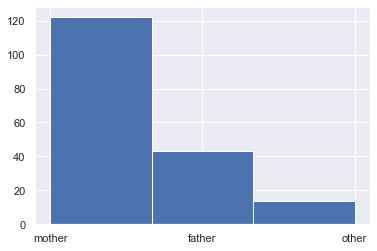

In [62]:
drow_nomin_hist(df, 'guardian', 3)

In [63]:
print_nomin_info(df, 'guardian')

,guardian
mother,122
father,43
nan,22
other,14


Значений, встретившихся в столбце более 10 раз: 4
Уникальных значений: 4
<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guardian  201 non-null    object
dtypes: object(1)
memory usage: 3.1+ KB


## 22. Столбец school_sup
дополнительная образовательная поддержка (yes или no)

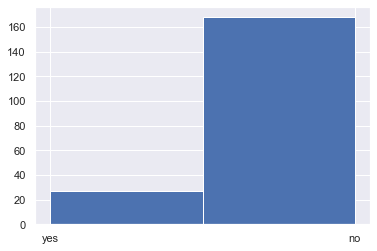

In [64]:
drow_nomin_hist(df, 'school_sup', 2)

In [65]:
print_nomin_info(df, 'school_sup')

,school_sup
no,168
yes,27
nan,6


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 3
<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school_sup  201 non-null    object
dtypes: object(1)
memory usage: 3.1+ KB


## 23. Столбец fam_sup
семейная образовательная поддержка (yes или no)

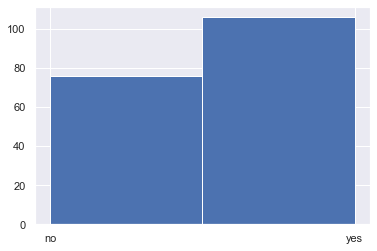

In [66]:
drow_nomin_hist(df, 'fam_sup', 2)

In [67]:
print_nomin_info(df, 'fam_sup')

,fam_sup
yes,106
no,76
nan,19


Значений, встретившихся в столбце более 10 раз: 3
Уникальных значений: 3
<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   fam_sup  201 non-null    object
dtypes: object(1)
memory usage: 3.1+ KB


## 24. Столбец paid 
дополнительные платные занятия по математике (yes или no)

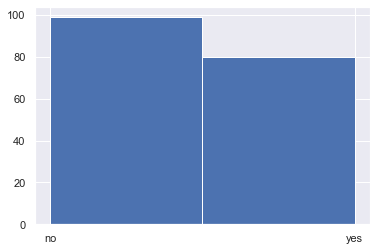

In [68]:
drow_nomin_hist(df, 'paid', 2)

In [69]:
print_nomin_info(df, 'paid')

,paid
no,99
yes,80
nan,22


Значений, встретившихся в столбце более 10 раз: 3
Уникальных значений: 3
<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   paid    201 non-null    object
dtypes: object(1)
memory usage: 3.1+ KB


## 25. Столбец activities
дополнительные внеучебные занятия (yes или no)

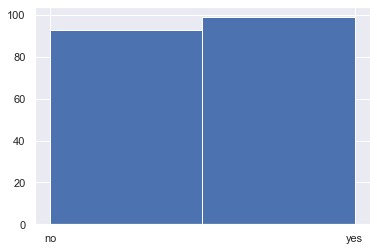

In [70]:
drow_nomin_hist(df, 'activities', 2)

In [71]:
print_nomin_info(df, 'activities')

,activities
yes,99
no,93
nan,9


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 3
<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  201 non-null    object
dtypes: object(1)
memory usage: 3.1+ KB


## 26. Столбец nursery 
посещал детский сад (yes или no)

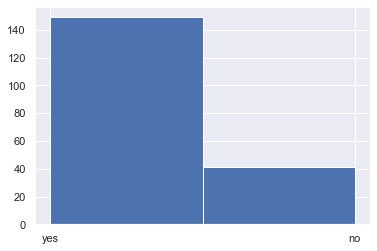

In [72]:
drow_nomin_hist(df, 'nursery', 2)

In [73]:
print_nomin_info(df, 'nursery')

,nursery
yes,149
no,41
nan,11


Значений, встретившихся в столбце более 10 раз: 3
Уникальных значений: 3
<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nursery  201 non-null    object
dtypes: object(1)
memory usage: 3.1+ KB


## 27. Столбец higher 
 хочет получить высшее образование (yes или no)

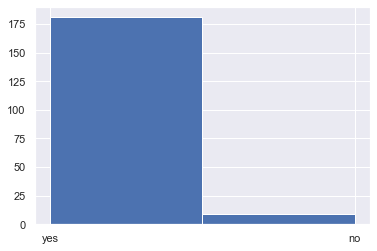

In [74]:
drow_nomin_hist(df, 'higher', 2)

In [75]:
print_nomin_info(df, 'higher')

,higher
yes,181
nan,11
no,9


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 3
<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   higher  201 non-null    object
dtypes: object(1)
memory usage: 3.1+ KB


## 28. Столбец internet 
наличие интернета дома (yes или no)

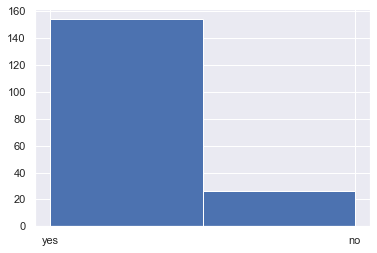

In [76]:
drow_nomin_hist(df, 'internet', 2)

In [77]:
print_nomin_info(df, 'internet')

,internet
yes,154
no,26
nan,21


Значений, встретившихся в столбце более 10 раз: 3
Уникальных значений: 3
<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   internet  201 non-null    object
dtypes: object(1)
memory usage: 3.1+ KB


## 29. Столбец romantic 
в романтических отношениях (yes или no)

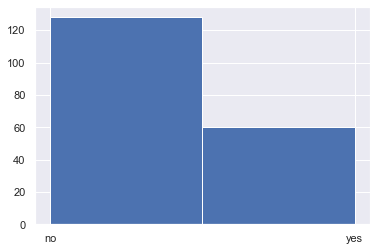

In [78]:
drow_nomin_hist(df, 'romantic', 2)

In [79]:
print_nomin_info(df, 'romantic')

,romantic
no,128
yes,60
nan,13


Значений, встретившихся в столбце более 10 раз: 3
Уникальных значений: 3
<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   romantic  201 non-null    object
dtypes: object(1)
memory usage: 3.1+ KB


# III Корреляционный анализ

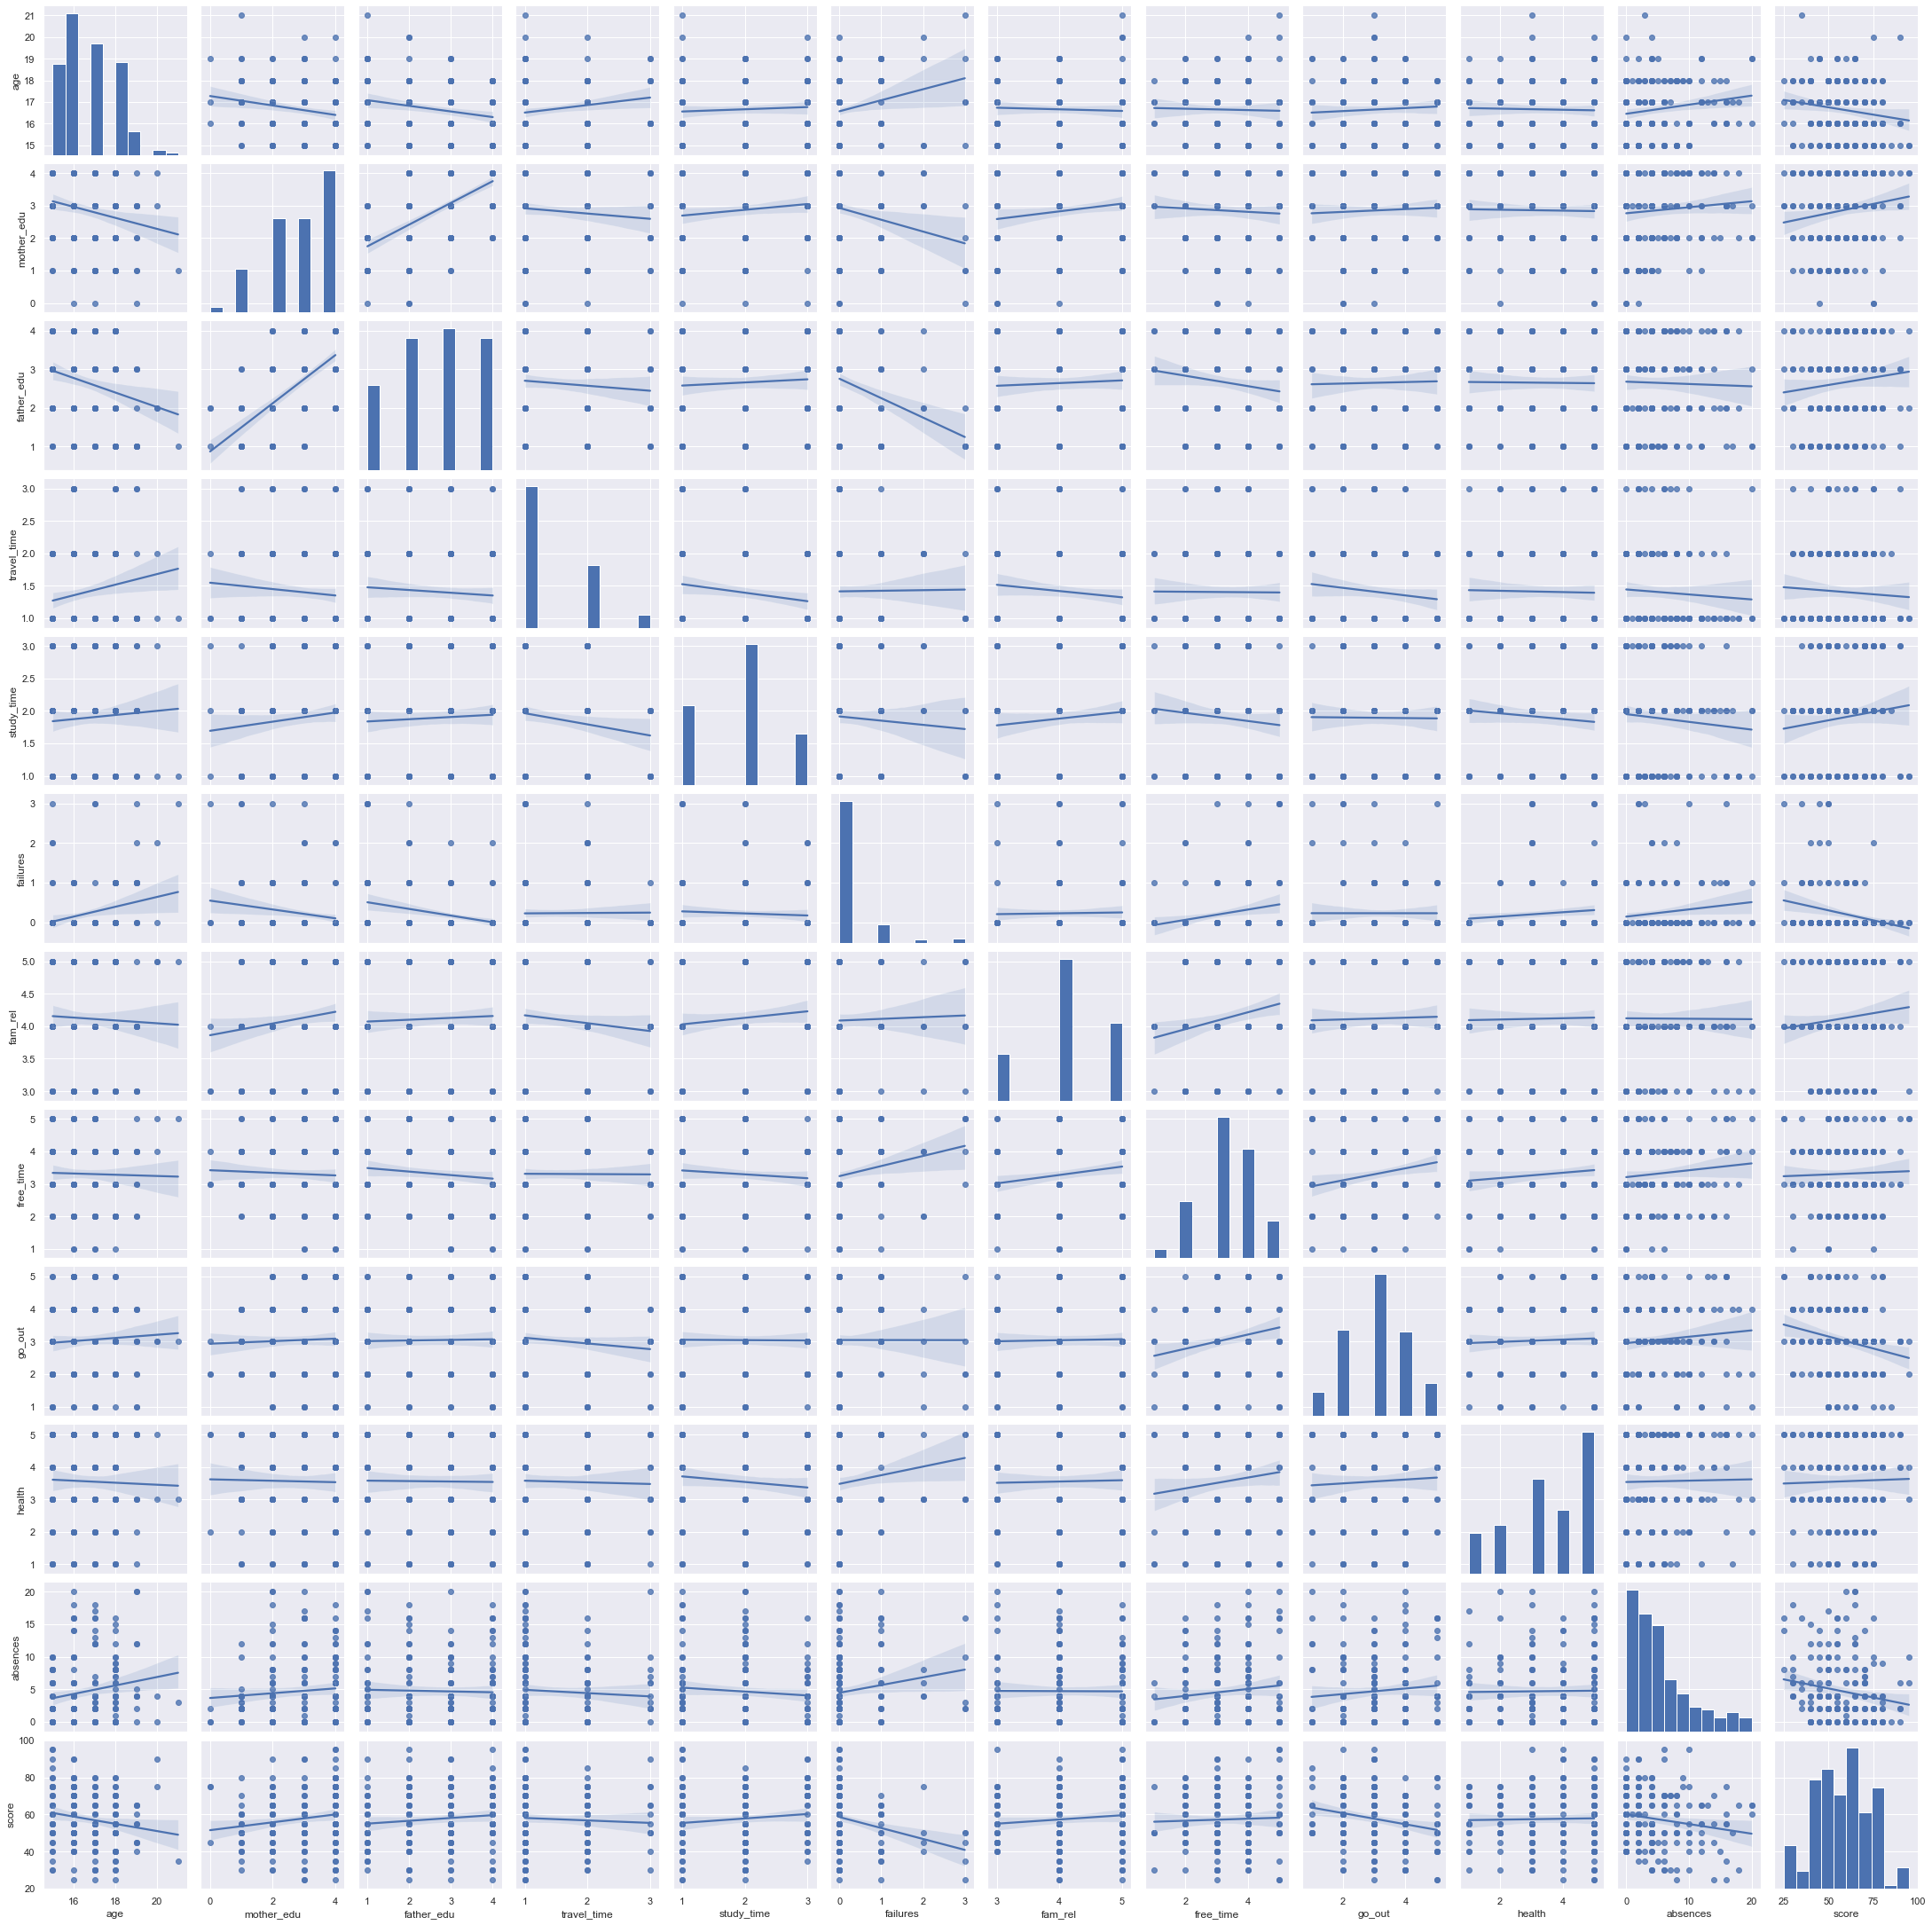

In [80]:
sns.pairplot(df, kind='reg')

In [81]:
df.corr().score.sort_values(ascending=False)

score          1.000000
mother_edu     0.155648
study_time     0.111770
father_edu     0.108244
fam_rel        0.103352
free_time      0.034733
health         0.022217
travel_time   -0.054122
age           -0.162826
absences      -0.170384
go_out        -0.210650
failures      -0.243593
Name: score, dtype: float64

Видно, что наибольшая положительная корреляция наблюдается между баллами по математике и:
    - образованием матери,
    - временем на учёбу помимо школы в неделю,
    - образованием отца,
    - cемейными отношениями.
Наибольшая отрицательная корреляция наблюдается между баллами по математике и:
    - количеством внеучебных неудач,
    - временем, проведенным с друзьями,
    - количеством пропущенных занятий,
    - возрастом.


# IV Анализ номинативных переменных

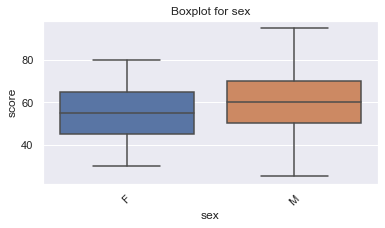

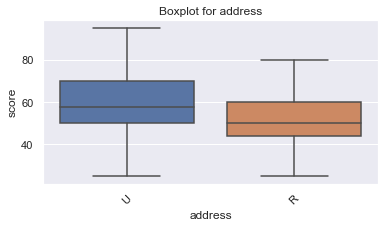

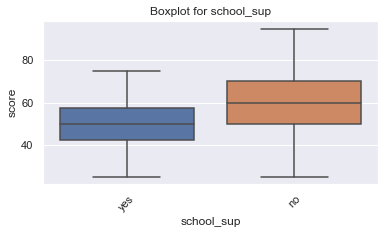

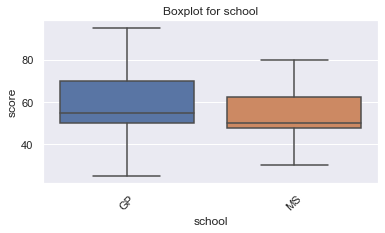

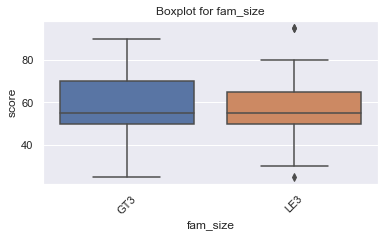

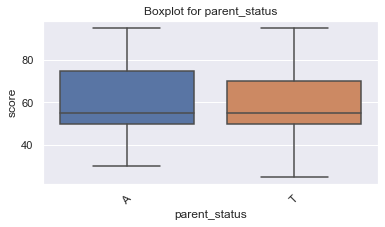

In [82]:
for col in [
        'sex', 'address', 'school_sup', 'school', 'fam_size', 'parent_status'
]:
    drow_nomin_boxplot(col)

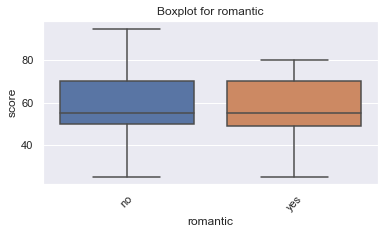

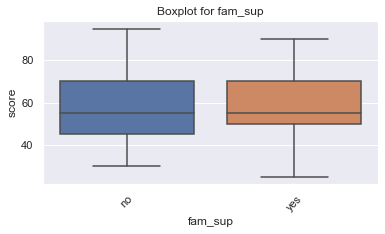

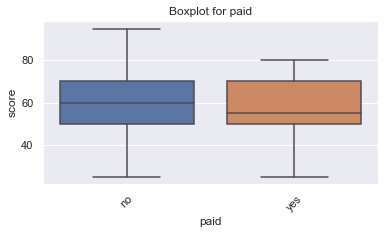

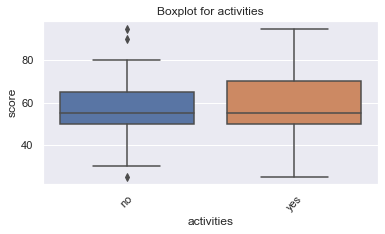

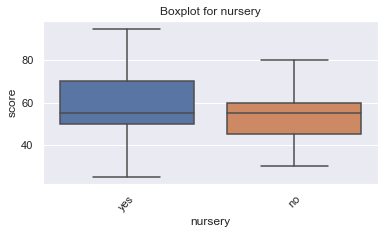

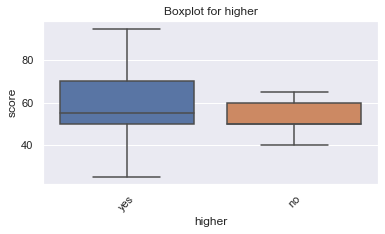

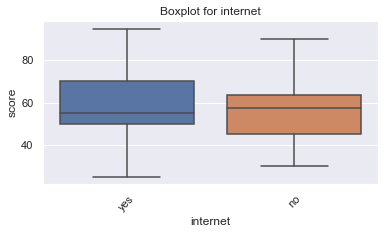

In [83]:
for col in [
        'romantic', 'fam_sup', 'paid', 'activities', 'nursery', 'higher',
        'internet'
]:
    drow_nomin_boxplot(col)

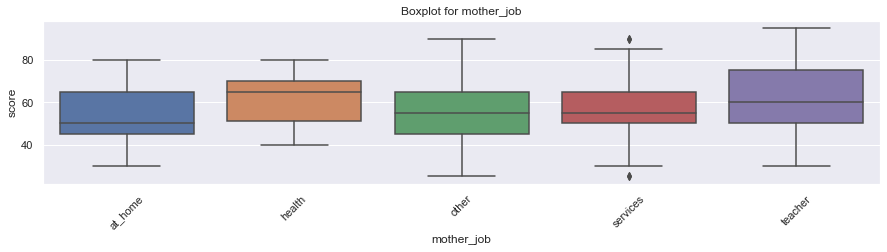

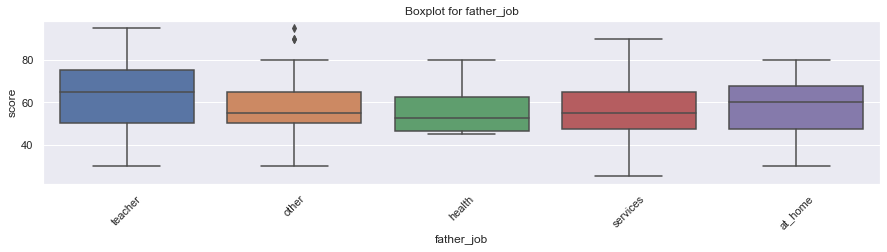

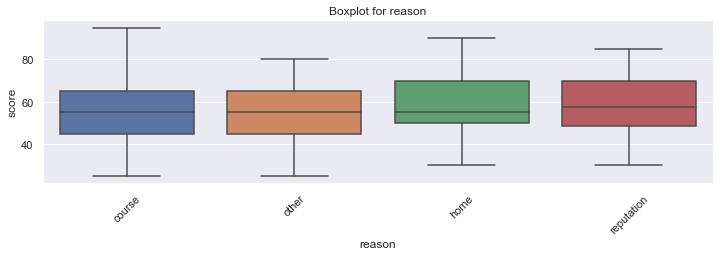

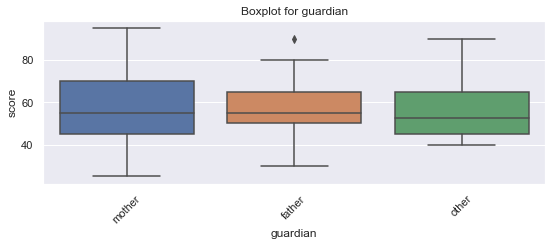

In [84]:
for col in ['mother_job', 'father_job', 'reason', 'guardian']:
    drow_nomin_boxplot(col)

In [85]:
for col in [
        'school', 'sex', 'address', 'fam_size', 'parent_status', 'school_sup',
        'fam_sup', 'paid', 'activities', 'nursery', 'higher', 'internet',
        'romantic', 'mother_job', 'father_job', 'reason', 'guardian'
]:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки school_sup


In [86]:
df_for_model = df.loc[:, [ 'sex', 'address', 'school_sup', 'mother_edu', 'study_time' , 'father_edu', 'fam_rel',
                          'age', 'absences', 'go_out', 'failures', 'score' ]]
df_for_model.head()

,sex,address,school_sup,mother_edu,study_time,father_edu,fam_rel,age,absences,go_out,failures,score
0,F,U,yes,4.0,2.0,4.0,4.0,18,6.0,4.0,0.0,30.0
1,F,U,no,1.0,2.0,1.0,5.0,17,4.0,3.0,0.0,30.0
2,F,U,yes,1.0,2.0,1.0,4.0,15,10.0,2.0,3.0,50.0
3,F,U,no,4.0,3.0,2.0,3.0,15,2.0,2.0,0.0,75.0
4,F,U,no,3.0,2.0,3.0,4.0,16,4.0,2.0,0.0,50.0


# V Выводы

В результате EDA для анализа влияния параметров шоколада на экспертную оценку шоколадных батончиков были получены следующие выводы:

1. В данных достаточно мало пустых значений.
2. Количнство выбросов небольшое, за исключением столбца failures (68 шт. после очистви выбросов числовых признаков)
3. Видно, что наибольшая положительная корреляция наблюдается между баллами по математике и:
    - образованием матери,
    - временем на учёбу помимо школы в неделю,
    - образованием отца,
    - cемейными отношениями.
    Т.е. чем более образованы родители, чем лучше отношения в семье и чем больше времени ученик занимается дополнительно, тем выше его оценка по математике.
    Наибольшая отрицательная корреляция наблюдается между баллами по       
    математике и:
    - количество внеучебных неудач,
    - временем, проведенным с друзьями,
    - количеством пропущенных занятий,
    - возрастом..
    Т.е. большое количество  внеучебных неудач, пропущенных занаятий, времени проведенного с друзьями и чем старше ученик, тем ниже его оценка по математике.
4. Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это 'sex', 'address', 'school_sup', 'mother_edu', 'study_time' , 'father_edu', 'fam_rel', 'age', 'absences', 'go_out', 'failures', 'score'.